Importacion de las funciones, parametros y librerias necesarias

In [1]:
from pathlib import Path
import sys, os
 
# setting path
directory = os.getcwd()
directory = os.path.dirname(directory)
sys.path.append(directory) if directory not in sys.path else None

# Import utils
from utils import * 
# Import training parameters
from hiperparameters import * 
# Import generator and discriminator model
from sngan_model.sngan_model_128 import *

import os, csv, random, cv2
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.optim as optim
from torchvision.utils import save_image
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

C:\Users\Sant Garcia\Documents\Tesis\Generate-mamographic-images\Datasets\Ultrasonido


Definión de estadisticas de los datos originales, para usar con el FID

In [2]:
#val = "mamografia_all"
val = "ultrasonido_all"
create_stats(val, data_path, device, "clean", batch_size)
#create_stats(val, data_path, device, "legacy_tensorflow", 1)

Datos para clean disponibles.


Se obtiene el tensor de las imagenes y se establece el valor de la semilla

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print(str(device).upper(),"| Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Create dataloader
dataloader = get_dataset(data_path, image_size, batch_size, workers)

CPU | Random Seed:  999
Train size: 1041


Muestra de imágenes reales

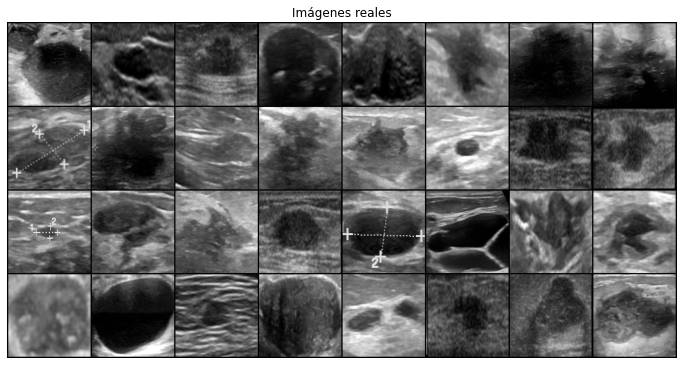

In [4]:
# Show a grid of ramdom real images
real_batch = next(iter(dataloader))
real_batch = real_batch[0]
title = "Imágenes reales"
show_grid_64(real_batch, device, title)

Se define el generador y el discriminador

In [6]:
# Create the generator
netG = Generator(nz).to(device)
# Create the Discriminator
netD = Discriminator().to(device)

Establecimiento de la función de perdida y los optimizadores

In [ ]:
#criterion = nn.BCELoss().cuda() # original
criterion = nn.BCEWithLogitsLoss().cuda()
fixed_noise = Variable(torch.randn(batch_size, nz).cuda())

# because the spectral normalization module creates parameters that don't require gradients (u and v), we don't want to
# optimize these using sgd. We only let the optimizer operate on parameters that _do_ require gradients
# TODO: replace Parameters with buffers, which aren't returned from .parameters() method.
optimizerD = optim.Adam(filter(lambda p: p.requires_grad, netD.parameters()), lr=lr, betas=(beta1, beta2))
optimizerG  = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# use an exponentially decaying learning rate
scheduler_d = optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)
scheduler_g = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)

Código de la ruta para guardar los datos del entrenamiento

In [7]:
f = list("AEIOSUMA1234567890XFGJOLDRTCH")
random.shuffle(f)
f = "".join(f)
name_coded=random_id(5, f)+"-" +str(image_size)
print(name_coded)

root = os.path.join(directory, 'experimentos') 
# Dir to save sampling grid images
img_folder = os.path.join(root, name_coded) + os.sep
print(img_folder)
# Dir to save evaluation images
img_save_path =  os.path.join(img_folder,'images') + os.sep
print(img_save_path)
# Dir to save checkpoints
checkpoint_dir = os.path.join(img_folder,'checkpoints') + os.sep
print(checkpoint_dir)

6RUMR-128
C:\Users\Sant Garcia\Documents\Tesis\Generate-mamographic-images\experimentos\images\
C:\Users\Sant Garcia\Documents\Tesis\Generate-mamographic-images\experimentos\6RUMR-128\
C:\Users\Sant Garcia\Documents\Tesis\Generate-mamographic-images\experimentos\6RUMR-128\checkpoints\


Cargar el modelo si es necesario

In [8]:
# Load model if its necesary
load_model = False
stat_start_train = "| Iniciando entrenamiento..."
checkpoint_file = os.path.join(checkpoint_dir ,'checkpoint.pth')
decision = ''

while True:
    decision = input("¿Desea empezar un nuevo entrenamiento? Responda 's', o 'n' para continuar una ejecucion previa")
    if decision == "s":
        load_model = False
        break
    elif decision == "n":
        load_model = True
        break
    else:
        continue
    
if load_model:
    try:
        checkpoint = torch.load(checkpoint_file)
        start_epoch = checkpoint['epoch']
        netG.load_state_dict(checkpoint['gen_state_dict'])
        netD.load_state_dict(checkpoint['dis_state_dict'])
        optimizerG.load_state_dict(checkpoint['gen_optimizer'])
        optimizerD.load_state_dict(checkpoint['dis_optimizer'])
        summary = checkpoint['summary']
        act_porc = checkpoint['act_porc']
        stat_start_train = "| Reanudando entrenamiento, época inicial: %d..." % start_epoch 
        print("Carga existosa. ")
        img_list = []
    except:
        print("No se ha podido cargar el modelo. Ruta del checkpoint no encontrada. ", checkpoint_file)
else:
    img_list = []
    summary = []
    act_porc = 0
    print("Nueva ejecución. ")
iters = 1

¿Desea empezar un nuevo entrenamiento? Responda 's', o 'n' para continuar una ejecucion previas
Nueva ejecución. 


Entrenamiento y validación de la red

In [ ]:
os.makedirs(img_folder, exist_ok=True)
os.makedirs(img_save_path, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# Create savelog
parm_list = [beta1, beta2, batch_size, lr, num_epochs, nz, image_size, str(netG), str(netD)]
create_savelog("cgan", img_folder, name_coded, parm_list)

print(today, stat_start_train)

# For each epoch
for epoch in range(start_epoch, num_epochs+1):
    k = 1
    folder_samples = img_save_path + str(epoch) + os.sep
    netG.train()
    percentaje = 100 * (epoch / num_epochs)
    #saving_model(epoch, percentaje, act_porc, checkpoint_dir, x)
    if divmod(percentaje, 10) == (act_porc, 0) and percentaje != 99:
        act_porc += 1
        save_checkpoint({
            'epoch': epoch,
            'gen_state_dict': netG.state_dict(),
            'dis_state_dict': netD.state_dict(),
            'gen_optimizer': optimizerG.state_dict(),
            'dis_optimizer': optimizerD.state_dict(),
            'act_porc': act_porc,
            'summary': summary,
        }, checkpoint_dir)
        print("%d%% | Modelo guardado en la época: %s" % (int(percentaje), str(epoch)))
    for batch_idx, (data, target) in enumerate(dataloader,0):
        if data.size()[0] != batch_size:
            continue
        data, target = Variable(data.cuda()), Variable(target.cuda())
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        for _ in range(disc_iters):
            noise = Variable(torch.randn(batch_size, nz).cuda())
            optimizerD.zero_grad()
            optimizerG.zero_grad()
            errD = criterion(
                netD(data), Variable(torch.ones(len(netD(data)), 1).cuda())) + \
                criterion(netD(netG(noise)), Variable(torch.zeros(len(netD(data)), 1).cuda()))
            # Calculate gradients for D
            errD.backward()
            # Update D
            optimizerD.step()

        noise = Variable(torch.randn(batch_size, nz).cuda())
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerD.zero_grad()
        optimizerG.zero_grad()
        errG = criterion(
            netD(netG(noise)), Variable(torch.ones(len(netD(data)), 1).cuda())
        )
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        # Get percentages of discriminator accuracy
        output_d = netD(data).view(-1)
        output_dg = netD(netG(noise)).view(-1)
        D_x = round(output_d.sigmoid().mean().item(), 4)
        D_G_z1 = round(output_dg.sigmoid().mean().item(), 4)
        score_clean = None
        score_tensor = None

        # Check how the generator is doing by saving G's output on fixed_noise
        if batch_idx + 2 == len(dataloader) :
            netG.eval()
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            title = "Época: " + str(epoch)
            route_to_save = img_folder + "%d-%d.png" % (epoch, iters + 1)
            grid = show_grid_64(fake.data, device, title, True, route_to_save)
            #img_list.append(grid)
            # FID evaluation each n epcohs
            if epoch % interval_evaluation == 0:
                os.makedirs(folder_samples, exist_ok=True)
                print("________________________________________________________________________________________________")
                with torch.no_grad():
                    for _ in tqdm(range(len(dataloader)), desc="Save "):
                        z = Variable(torch.randn(batch_size, nz).to(device))
                        fake = netG(z)
                        for y in fake.data:
                            save_image(y, folder_samples + "%d(%d)-%d.png" % (epoch, k, iters + 1), normalize=True)
                            k += 1
                score_clean = fid.compute_fid(folder_samples, dataset_name=val, mode="clean", num_workers=0, batch_size=batch_size, device=device, dataset_split="custom")
                #score_tensor= fid.compute_fid(folder_samples, dataset_name=val, mode="legacy_tensorflow", num_workers=0, batch_size=1, device=device, dataset_split="custom")

            print(check_epochs_values(epoch, num_epochs, errD.item(), errG.item(), D_x, D_G_z1, 0, score_clean, score_tensor))
            create_data_summary(img_folder, summary)
        iters += 1
    summary.append((errD.item(), errG.item(), D_x, D_G_z1, 0, score_clean, score_tensor))
    scheduler_d.step()
    scheduler_g.step()

Graficar los resultados del entrenamiento.

In [ ]:
data_summary = pd.read_csv(img_folder + 'data_summary.csv', sep = ",")

generate_plot(data_summary, "loss", "#FA5D32", "#163B6E", img_folder)
generate_plot(data_summary, "scores", "#2FB563", "#D71220", img_folder)
generate_plot(data_summary, "fid-clean", "#E33977", "#D71220", img_folder)

Graficar los últimos resultados del entrenamiento

In [ ]:
# Plot the fake images from the last epoch
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Imágenes generadas en la última epoca")
plt.imshow(img_list[-1])
plt.show()

Evolución del entrenamiento de las imágenes

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())